https://www.kaggle.com/code/shivamb/semi-supervised-classification-using-autoencoders/notebook

In [2]:
import pandas as pd
import random
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

## Read csv files

In [3]:
X_train = pd.read_csv('Data/X_train.csv')
X_test = pd.read_csv('Data/X_test.csv')
Y_train = pd.read_csv('Data/Y_train.csv')
Y_test = pd.read_csv('Data/Y_test.csv')

In [4]:
X_train.head()

,index,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,3262,75.0,1,0,91.85,21.4,1,0,0,0,0,1,0,1,0,0
1,3267,2.0,0,0,99.75,16.0,1,0,0,0,0,0,0,0,0,0
2,1407,77.0,0,0,100.85,29.5,1,1,0,0,1,0,0,0,0,1
3,1385,45.0,0,0,89.05,27.8,1,1,0,0,1,0,1,1,0,0
4,3600,27.0,0,0,82.05,21.0,1,0,0,0,1,0,1,0,0,0


In [5]:
X_train.drop(['index'], axis = 1, inplace=True)
X_test.drop(['index'], axis = 1, inplace=True)
Y_train.drop(['index'], axis = 1, inplace=True)
Y_test.drop(['index'], axis = 1, inplace=True)

In [6]:
X_train.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,75.0,1,0,91.85,21.4,1,0,0,0,0,1,0,1,0,0
1,2.0,0,0,99.75,16.0,1,0,0,0,0,0,0,0,0,0
2,77.0,0,0,100.85,29.5,1,1,0,0,1,0,0,0,0,1
3,45.0,0,0,89.05,27.8,1,1,0,0,1,0,1,1,0,0
4,27.0,0,0,82.05,21.0,1,0,0,0,1,0,1,0,0,0


In [7]:
Y_train.head()

,stroke
0,0
1,0
2,0
3,0
4,0


In [8]:
sum(Y_train['stroke']==1)

194

## Condider only 500 rows of healthy cases

Combine the X_train and Y_train together before sampling.

In [25]:
merged_df = pd.concat([X_train,Y_train],axis=1)

In [26]:
merged_df

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,75.0,1,0,91.85,21.4,1,0,0,0,0,1,0,1,0,0,0
1,2.0,0,0,99.75,16.0,1,0,0,0,0,0,0,0,0,0,0
2,77.0,0,0,100.85,29.5,1,1,0,0,1,0,0,0,0,1,0
3,45.0,0,0,89.05,27.8,1,1,0,0,1,0,1,1,0,0,0
4,27.0,0,0,82.05,21.0,1,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4082,46.0,0,0,102.27,38.9,0,1,1,0,0,0,0,1,0,0,0
4083,81.0,0,0,89.02,26.9,0,1,1,0,0,0,0,0,1,0,0
4084,80.0,0,1,103.06,28.8,1,1,0,0,0,1,0,0,1,0,0
4085,77.0,0,0,250.80,32.9,1,1,0,0,1,0,1,0,1,0,0


In [28]:
random.seed(10)
health = merged_df[merged_df['stroke'] == 0].sample(500)
stroke = merged_df[merged_df['stroke'] == 1]

df = health.append(stroke).sample(frac=1).reset_index(drop=True)
X = df.drop(['stroke'], axis = 1).values
Y = df["stroke"].values

/var/folders/0s/xfpwvv6x0fg3pkqm99zxr6z40000gq/T/ipykernel_74630/1891580377.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = health.append(stroke).sample(frac=1).reset_index(drop=True)


In [30]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Health')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Stroke')

    plt.legend(loc='best')
    #plt.savefig(name)
    plt.show()

#function for plotting tsne representation

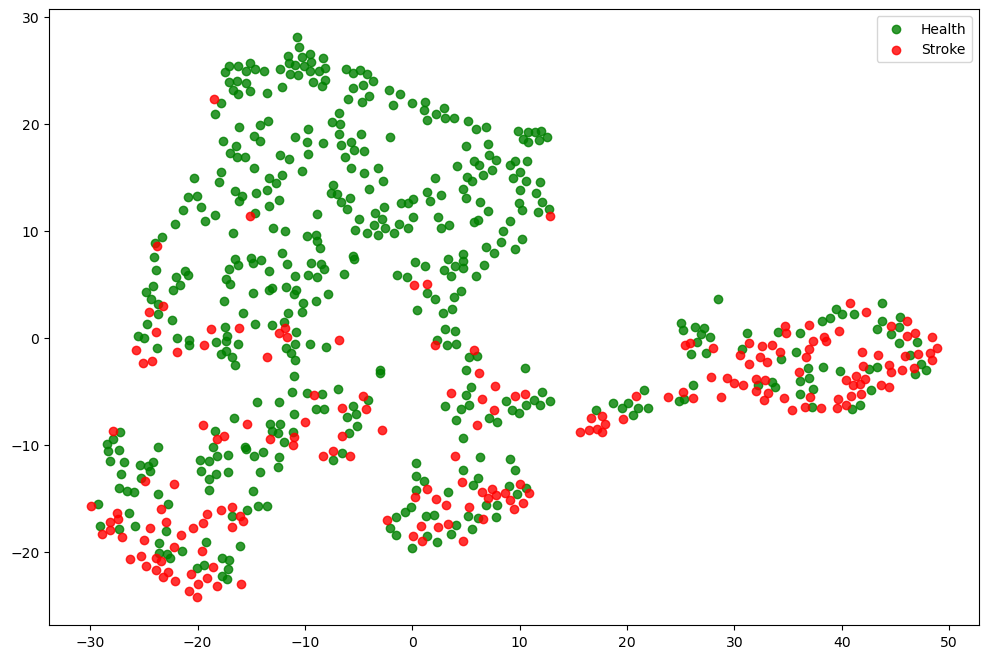

In [31]:
tsne_plot(X, Y, "original.png")

From the above plot, we can see that quite a lot of the health and stroke cases are mixed together, in this case, classification model will not be able to separate them very well. We want to try to use auto encoder to improve the situation.

### Define the auto encoder model

In [32]:
input_layer = Input(shape=(X.shape[1],))

encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

output_layer = Dense(X.shape[1], activation='relu')(decoded)

2023-03-14 12:19:11.458288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

Perform min max transform before training.

In [34]:
x_scale = preprocessing.MinMaxScaler().fit_transform(X_train.values)
x_health, x_stroke= x_scale[Y_train['stroke'] == 0], x_scale[Y_train['stroke'] == 1]

In [55]:
autoencoder.fit(x_health[0:1000], x_health[0:1000], 
                batch_size = 2, epochs = 10, 
                shuffle = True, validation_split = 0.20)

Epoch 1/10
400/400 [==============================] - 0s 1ms/step - loss: 0.1106 - val_loss: 0.1149
Epoch 2/10
400/400 [==============================] - 1s 1ms/step - loss: 0.1093 - val_loss: 0.1137
Epoch 3/10
400/400 [==============================] - 0s 1ms/step - loss: 0.1081 - val_loss: 0.1125
Epoch 4/10
400/400 [==============================] - 0s 961us/step - loss: 0.1069 - val_loss: 0.1114
Epoch 5/10
400/400 [==============================] - 0s 1ms/step - loss: 0.1058 - val_loss: 0.1104
Epoch 6/10
400/400 [==============================] - 0s 1ms/step - loss: 0.1047 - val_loss: 0.1093
Epoch 7/10
400/400 [==============================] - 0s 963us/step - loss: 0.1037 - val_loss: 0.1083
Epoch 8/10
400/400 [==============================] - 0s 1ms/step - loss: 0.1027 - val_loss: 0.1073
Epoch 9/10
400/400 [==============================] - 0s 956us/step - loss: 0.1017 - val_loss: 0.1064
Epoch 10/10
400/400 [==============================] - 0s 1ms/step - loss: 0.1008 - val_loss: 

Obtain the Latent Representations

In [56]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [57]:
health_hid_rep = hidden_representation.predict(x_health)
stroke_hid_rep = hidden_representation.predict(x_stroke)

7/7 [==============================] - 0s 718us/step


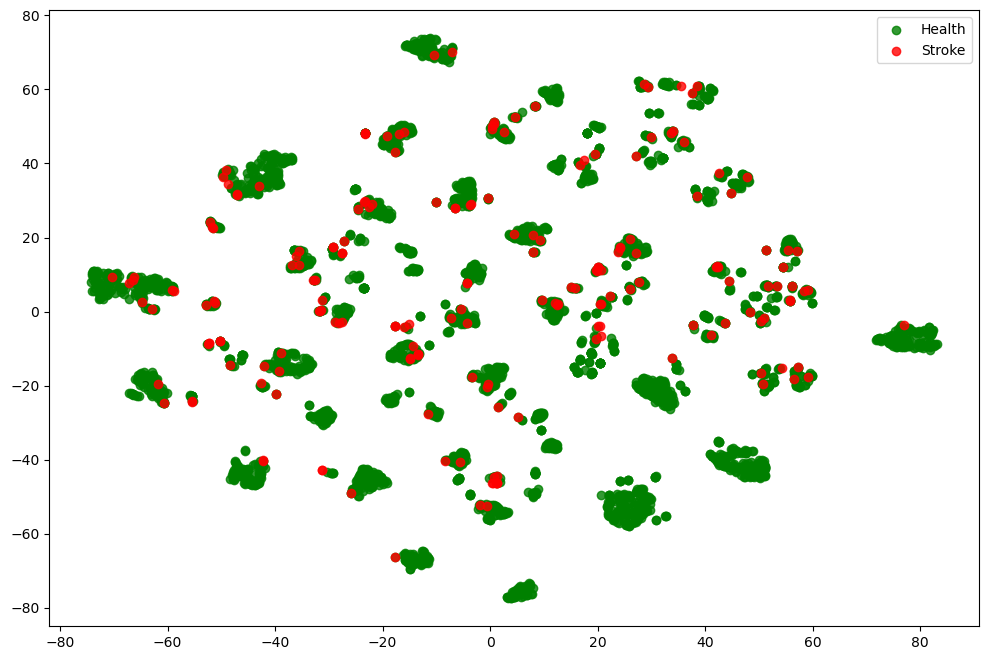

In [58]:
rep_x = np.append(health_hid_rep, stroke_hid_rep, axis = 0)
y_n = np.zeros(health_hid_rep.shape[0])
y_f = np.ones(stroke_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")